<a href="https://colab.research.google.com/github/Mahirtayeb1/Tea-Leaf-Disease-Detection-using-CNN/blob/main/Tea_Leaf_Disease_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import PIL
import glob
import keras
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn import preprocessing, linear_model
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten
from tensorflow.keras.utils import to_categorical, plot_model, get_file
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
# !pip install Augmentor
# !pip install split-folders[full]
# !pip install Augmentor Pillow

2024-04-24 03:05:59.805815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 03:06:02.619881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-24 03:06:02.620078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-24 03:06:02.620088: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
root_path = '/mnt/d/Tea leaf DL'
dataset_path = os.path.join(root_path,"Tea_leaf_disease_dataset_combined") #"/content/drive/MyDrive/Thesis P3/new_citrus_leaves"
weight_path =  os.path.join(root_path,"tea_weights")

In [ ]:
num_of_images = {}

for dir in os.listdir(dataset_path):
  num_of_images[dir] = len(os.listdir(os.path.join(dataset_path, dir)))

In [ ]:
os.getcwd()

'/home/mafatay'

In [ ]:
src = os.listdir(dataset_path)
src

['algal_spot',
 'bird eye spot_oversample',
 'brown_blight',
 'gray_blight',
 'healthy',
 'helopeltis',
 'red_spot']

In [ ]:
num_of_images.items()

dict_items([('algal_spot', 1000), ('bird eye spot_oversample', 1095), ('brown_blight', 867), ('gray_blight', 1000), ('healthy', 1000), ('helopeltis', 1000), ('red_spot', 1001)])

In [ ]:
# import Augmentor

# for folder in src:
#   p = Augmentor.Pipeline(
#                           source_directory= os.path.join(dataset_path, folder),
#                           output_directory= os.path.join(root_path, "aug_dataset", "aug_"+folder))

#   p.rotate(probability=0.2, max_left_rotation=2, max_right_rotation=2)
#   p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
#   p.skew(probability=0.2)
#   p.random_distortion(probability=0.2, grid_width=100, grid_height=100, magnitude=1)
#   p.shear(probability=0.2, max_shear_left=2, max_shear_right=2)
#   p.crop_random(probability=0.2, percentage_area=0.8)
#   p.flip_random(probability=0.2)
#   p.sample(700)

In [ ]:
import Augmentor

# Step 1: Set up Augmentor pipeline
input_dir = os.path.join(root_path, "tea sickness dataset", "bird eye spot")
output_dir = os.path.join(root_path, "bird eye spot_oversample")

pipeline = Augmentor.Pipeline(source_directory=input_dir, output_directory=output_dir)

# Step 2: Define augmentation operations
pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
pipeline.flip_left_right(probability=0.5)
pipeline.flip_top_bottom(probability=0.5)
pipeline.zoom_random(probability=0.5, percentage_area=0.8)
pipeline.flip_random(probability=0.5)
pipeline.rotate_random_90(probability=0.5)
pipeline.random_contrast(probability=0.5, min_factor=0.5, max_factor=1.5)
pipeline.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)

# Step 3: Generate augmented samples
num_samples = 1000  # Number of augmented samples to generate
pipeline.sample(num_samples)

# Step 4: Export augmented images
pipeline.process()


Initialised with 95 image(s) found.
Output directory set to /mnt/d/Tea leaf DL/bird eye spot_oversample.

Processing <PIL.Image.Image image mode=RGB size=4160x3120 at 0x7F88DA4D3700>: 100%|█| 1000/1000 [02:50<00:00,  5.86 Samp
Processing <PIL.Image.Image image mode=RGB size=3120x4160 at 0x7F88DA4D30A0>: 100%|█| 95/95 [00:15<00:00,  6.07 Samples/


In [ ]:
import splitfolders

input_folder = os.path.join(dataset_path)
splitfolders.ratio(input_folder, output= os.path.join(root_path, "split_tea_dataset"),
    seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)

Copying files: 6963 files [03:27, 33.60 files/s]


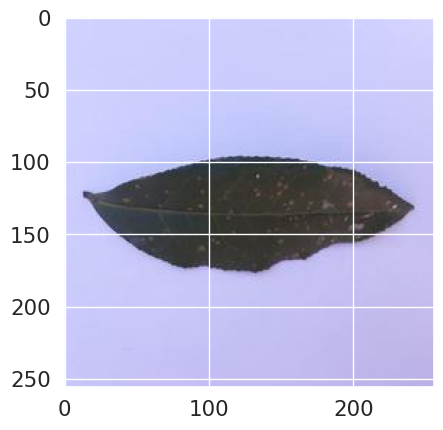

In [ ]:
temp_dir = os.path.join(root_path, 'split_tea_dataset', 'train', 'algal_spot')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[0]))
plt.imshow(img)

In [ ]:
cv2.imread(os.path.join(temp_dir,os.listdir(temp_dir)[0])).shape

(256, 256, 3)

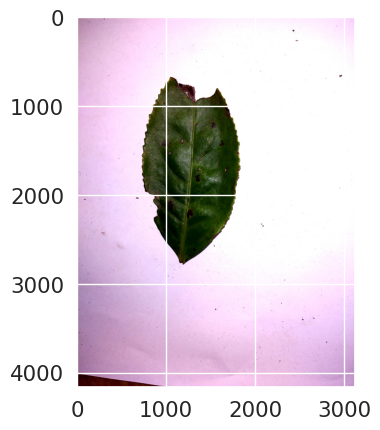

In [ ]:
temp_dir = os.path.join(root_path, 'split_tea_dataset', 'train', 'bird eye spot_oversample')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[154]))
plt.imshow(img)

In [ ]:
cv2.imread(os.path.join(temp_dir,os.listdir(temp_dir)[154])).shape

(4160, 3120, 3)

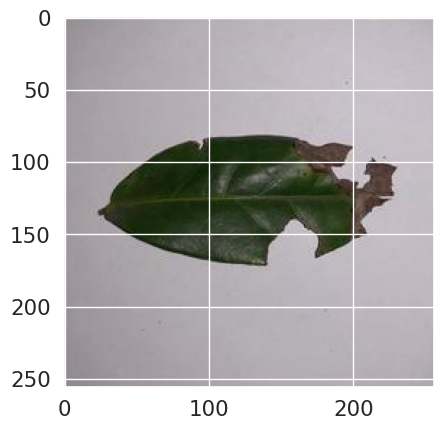

In [ ]:
temp_dir = os.path.join(root_path, 'split_tea_dataset', 'train', 'brown_blight')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[54]))
plt.imshow(img)

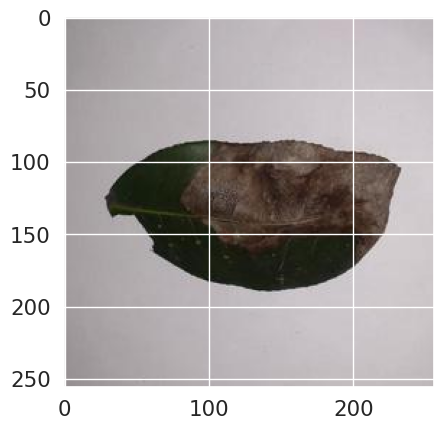

In [ ]:
temp_dir = os.path.join(root_path, 'split_tea_dataset', 'train', 'gray_blight')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[1]))
plt.imshow(img)

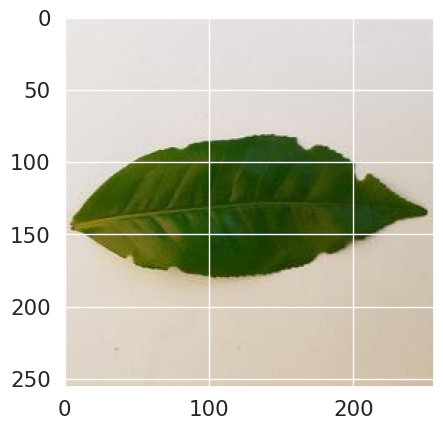

In [ ]:
temp_dir = os.path.join(root_path, 'split_tea_dataset', 'train', 'healthy')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[5]))
plt.imshow(img)

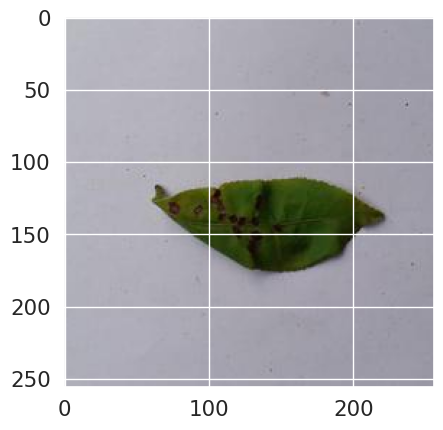

In [ ]:
temp_dir = os.path.join(root_path, 'split_tea_dataset', 'train', 'helopeltis')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[4]))
plt.imshow(img)

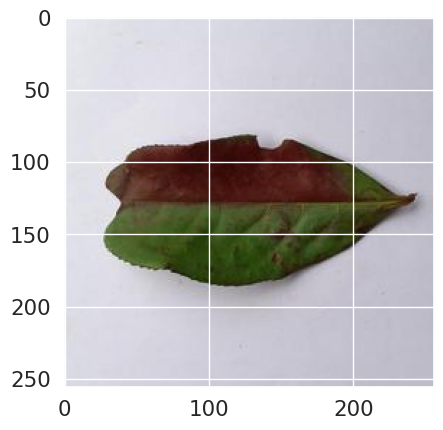

In [ ]:
temp_dir = os.path.join(root_path, 'split_tea_dataset', 'train', 'red_spot')
img = image.load_img(os.path.join(temp_dir,os.listdir(temp_dir)[1]))
plt.imshow(img)

In [ ]:
split_dataset_path = os.path.join(root_path, 'split_tea_dataset') #"/content/drive/MyDrive/Undergrad Thesis/Aug_split_fix"
fnames = os.listdir(split_dataset_path)
len(fnames)

3

In [ ]:
fnames

['test', 'train', 'val']

In [ ]:
fnames
split_data = os.listdir(os.path.join(split_dataset_path, fnames[1]))
split_data

['algal_spot',
 'bird eye spot_oversample',
 'brown_blight',
 'gray_blight',
 'healthy',
 'helopeltis',
 'red_spot']

Custom CNN

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale pixel values to the range [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(split_dataset_path, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # Using 'categorical' for multi-class classification
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    os.path.join(split_dataset_path, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(split_dataset_path, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4872 images belonging to 7 classes.
Found 1044 images belonging to 7 classes.
Found 1047 images belonging to 7 classes.


In [ ]:
def create_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))


    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))  # Dropout for regularization

    model.add(Dense(7, activation='softmax'))

    # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 26, 26, 128)     

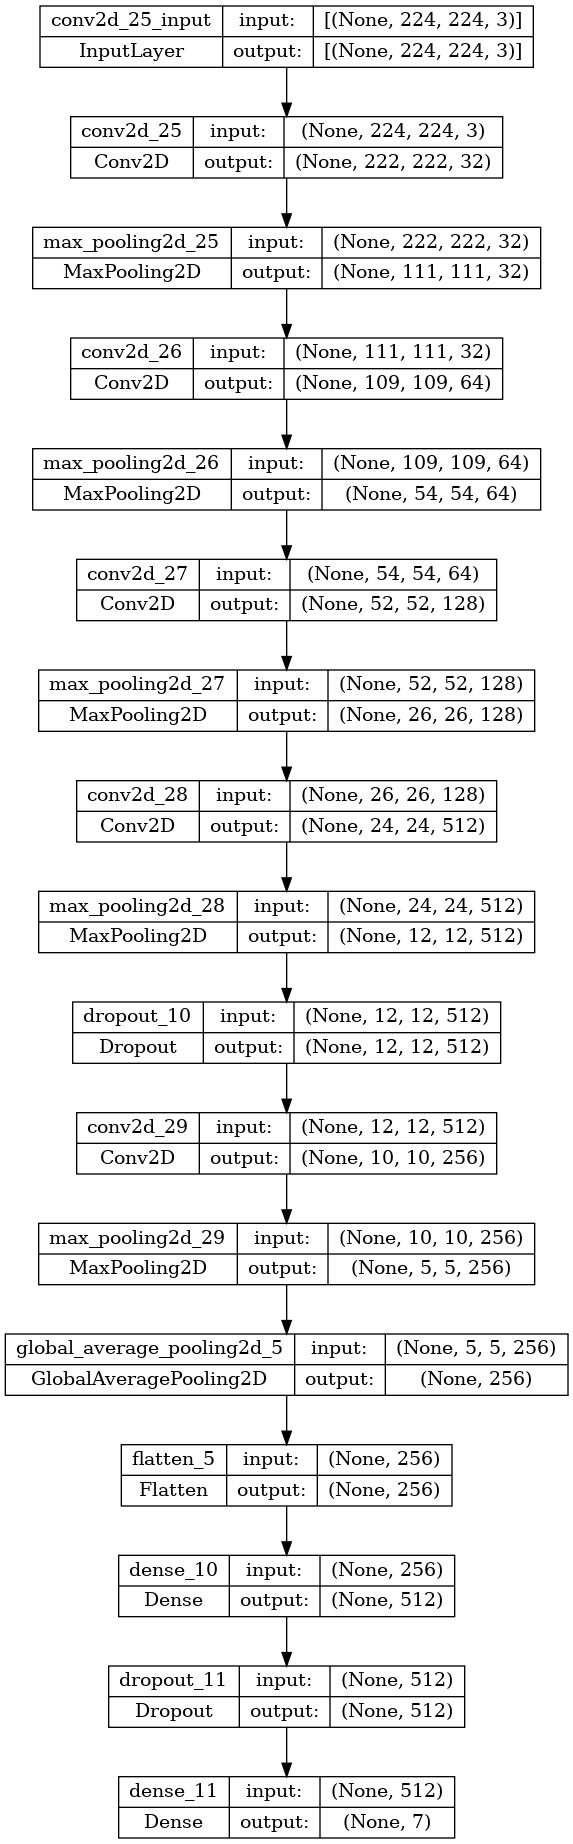

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
import time
start = time.process_time()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks = [reduce_lr]
)

Epoch 1/10


2024-04-24 04:55:18.912791: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


153/153 [==============================] - 110s 706ms/step - loss: 1.5166 - accuracy: 0.3500 - val_loss: 1.2525 - val_accuracy: 0.4205 - lr: 6.0000e-04
Epoch 2/10
153/153 [==============================] - 109s 713ms/step - loss: 1.2061 - accuracy: 0.4945 - val_loss: 1.0332 - val_accuracy: 0.5718 - lr: 6.0000e-04
Epoch 3/10
153/153 [==============================] - 108s 707ms/step - loss: 1.0731 - accuracy: 0.5579 - val_loss: 1.2740 - val_accuracy: 0.5192 - lr: 6.0000e-04
Epoch 4/10
153/153 [==============================] - 109s 709ms/step - loss: 0.9729 - accuracy: 0.5993 - val_loss: 0.9377 - val_accuracy: 0.5996 - lr: 6.0000e-04
Epoch 5/10
153/153 [==============================] - 108s 707ms/step - loss: 0.9045 - accuracy: 0.6242 - val_loss: 0.9455 - val_accuracy: 0.6245 - lr: 6.0000e-04
Epoch 6/10
153/153 [==============================] - 110s 715ms/step - loss: 0.7519 - accuracy: 0.7046 - val_loss: 0.8136 - val_accuracy: 0.6820 - lr: 6.0000e-04
Epoch 7/10
153/153 [=============

In [ ]:
print(time.process_time() - start)

1038.3387441999994


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weight_path,'Custom_cnn.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

33/33 [==============================] - 17s 516ms/step - loss: 0.3795 - accuracy: 0.8539
Test Accuracy: 0.8538681864738464


In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

Best Validation Accuracy: 0.8860152959823608
Corresponding Training Accuracy: 0.8199917674064636


In [ ]:
loaded_model = load_model(os.path.join(weight_path,'Custom_cnn.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

33/33 [==============================] - 14s 409ms/step - loss: 0.3795 - accuracy: 0.8539
Test Accuracy: 0.8538681864738464


33/33 [==============================] - 13s 402ms/step


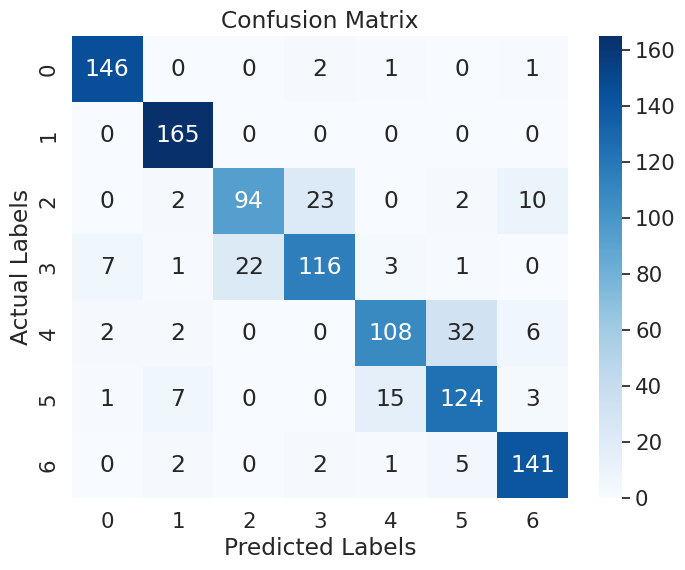

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       150
           1       0.92      1.00      0.96       165
           2       0.81      0.72      0.76       131
           3       0.81      0.77      0.79       150
           4       0.84      0.72      0.78       150
           5       0.76      0.83      0.79       150
           6       0.88      0.93      0.90       151

    accuracy                           0.85      1047
   macro avg       0.85      0.85      0.85      1047
weighted avg       0.85      0.85      0.85      1047



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

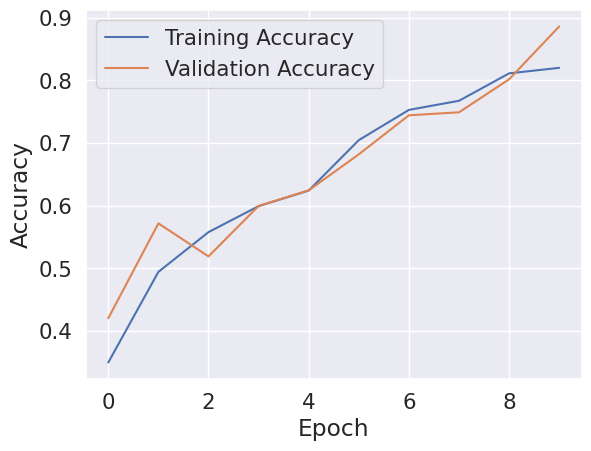

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

RESNET-50

In [ ]:
train_dir = os.path.join(split_dataset_path, 'train')
test_dir = os.path.join(split_dataset_path, 'test')
val_dir = os.path.join(split_dataset_path, 'val')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For 5 classes
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4872 images belonging to 7 classes.
Found 1044 images belonging to 7 classes.
Found 1047 images belonging to 7 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

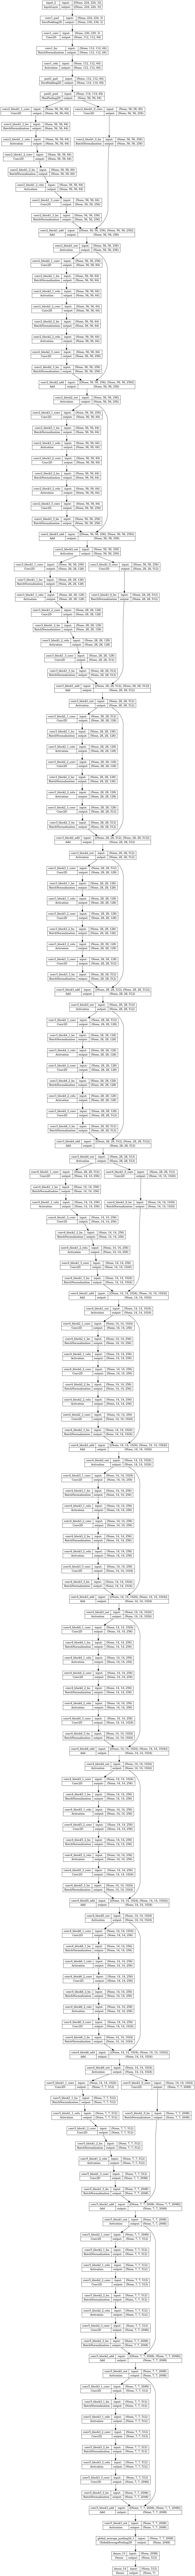

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
import time
start = time.process_time()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr]
)

Epoch 1/10
153/153 [==============================] - 141s 727ms/step - loss: 0.3078 - accuracy: 0.8970 - val_loss: 3.1049 - val_accuracy: 0.1456 - lr: 1.0000e-04
Epoch 2/10
153/153 [==============================] - 110s 721ms/step - loss: 0.1327 - accuracy: 0.9559 - val_loss: 3.2295 - val_accuracy: 0.1561 - lr: 1.0000e-04
Epoch 3/10
153/153 [==============================] - 112s 733ms/step - loss: 0.1134 - accuracy: 0.9639 - val_loss: 6.6983 - val_accuracy: 0.1571 - lr: 1.0000e-04
Epoch 4/10
153/153 [==============================] - 112s 730ms/step - loss: 0.0715 - accuracy: 0.9752 - val_loss: 3.3778 - val_accuracy: 0.1466 - lr: 1.0000e-04
Epoch 5/10
153/153 [==============================] - 111s 728ms/step - loss: 0.0315 - accuracy: 0.9889 - val_loss: 1.6525 - val_accuracy: 0.5374 - lr: 5.0000e-05
Epoch 6/10
153/153 [==============================] - 112s 731ms/step - loss: 0.0267 - accuracy: 0.9916 - val_loss: 1.0180 - val_accuracy: 0.6877 - lr: 5.0000e-05
Epoch 7/10
153/153 [==

In [ ]:
print(time.process_time() - start)

1285.5469336999995


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weight_path,'Resnet.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 14s 428ms/step - loss: 0.0160 - accuracy: 0.9933
Test Loss: 0.01599401980638504
Test Accuracy: 0.9933142066001892


In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

Best Validation Accuracy: 0.9932950139045715
Corresponding Training Accuracy: 0.9942528605461121


In [ ]:
loaded_model = load_model(os.path.join(weight_path,'Resnet.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = loaded_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 14s 413ms/step - loss: 0.0160 - accuracy: 0.9933
Test Loss: 0.01599401980638504
Test Accuracy: 0.9933142066001892


33/33 [==============================] - 14s 421ms/step


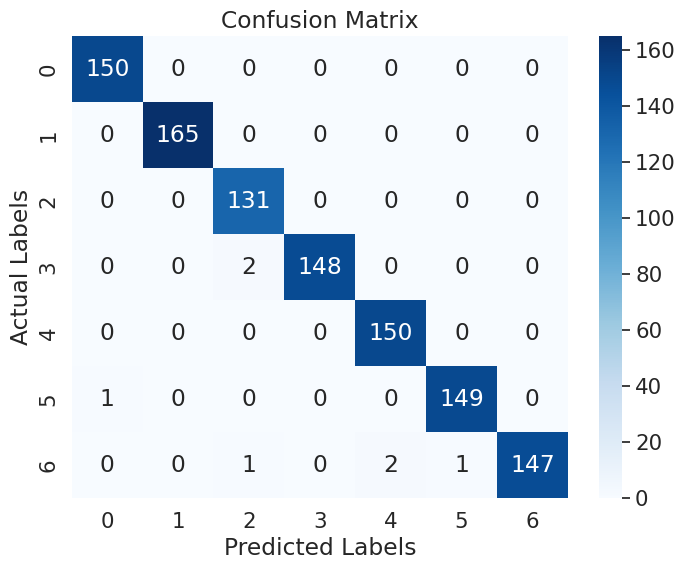

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      1.00      1.00       165
           2       0.98      1.00      0.99       131
           3       1.00      0.99      0.99       150
           4       0.99      1.00      0.99       150
           5       0.99      0.99      0.99       150
           6       1.00      0.97      0.99       151

    accuracy                           0.99      1047
   macro avg       0.99      0.99      0.99      1047
weighted avg       0.99      0.99      0.99      1047



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)


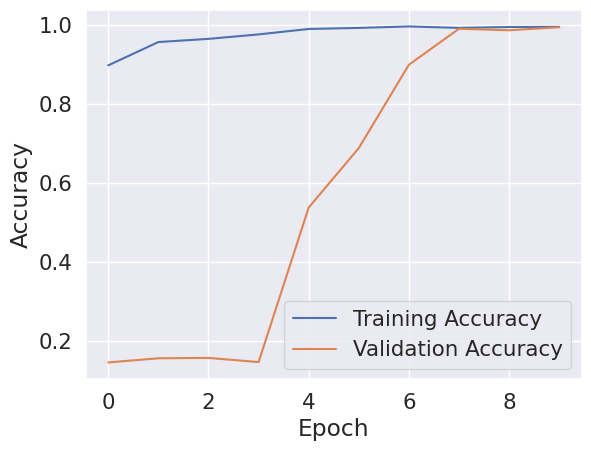

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

VGG-16

In [ ]:
train_dir = os.path.join(split_dataset_path, 'train')
test_dir = os.path.join(split_dataset_path, 'test')
val_dir = os.path.join(split_dataset_path, 'val')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4872 images belonging to 7 classes.
Found 1044 images belonging to 7 classes.
Found 1047 images belonging to 7 classes.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

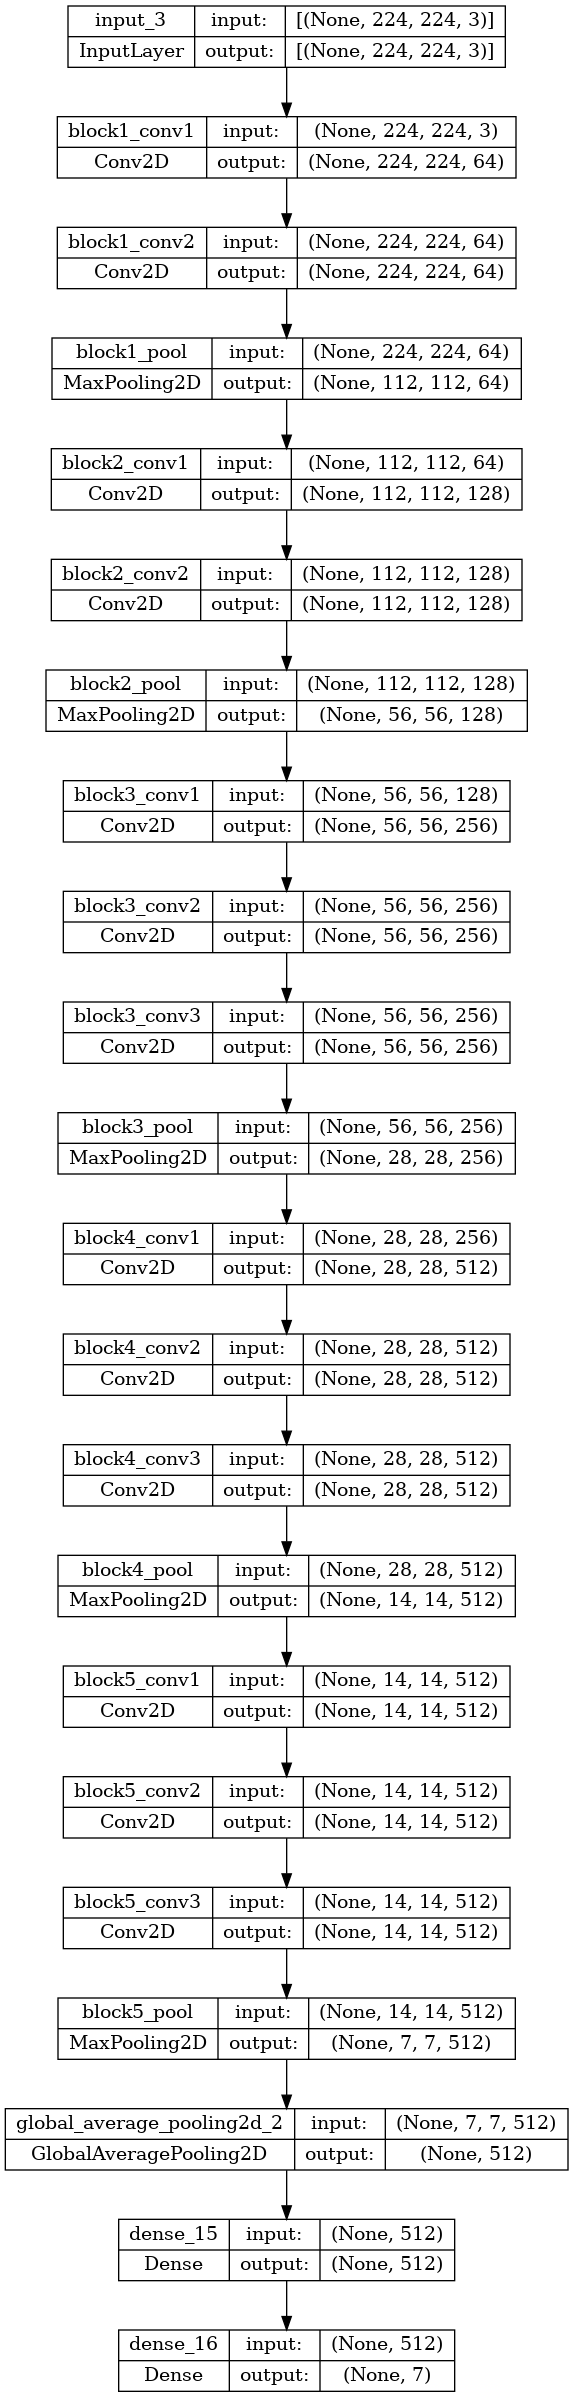

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
import time
start = time.process_time()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr]
)

Epoch 1/10
153/153 [==============================] - 123s 750ms/step - loss: 1.4210 - accuracy: 0.4115 - val_loss: 0.8041 - val_accuracy: 0.6456 - lr: 1.0000e-04
Epoch 2/10
153/153 [==============================] - 112s 729ms/step - loss: 0.7507 - accuracy: 0.6927 - val_loss: 0.4973 - val_accuracy: 0.7759 - lr: 1.0000e-04
Epoch 3/10
153/153 [==============================] - 112s 733ms/step - loss: 0.3817 - accuracy: 0.8695 - val_loss: 0.2391 - val_accuracy: 0.9205 - lr: 1.0000e-04
Epoch 4/10
153/153 [==============================] - 111s 724ms/step - loss: 0.2429 - accuracy: 0.9275 - val_loss: 0.1854 - val_accuracy: 0.9444 - lr: 1.0000e-04
Epoch 5/10
153/153 [==============================] - 111s 727ms/step - loss: 0.1901 - accuracy: 0.9429 - val_loss: 0.0995 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 6/10
153/153 [==============================] - 114s 742ms/step - loss: 0.1869 - accuracy: 0.9446 - val_loss: 0.1078 - val_accuracy: 0.9674 - lr: 1.0000e-04
Epoch 7/10
153/153 [==

In [ ]:
print(time.process_time() - start)

1310.2951467000003


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weight_path,'vgg.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 16s 492ms/step - loss: 0.0630 - accuracy: 0.9819
Test Loss: 0.06300211697816849
Test Accuracy: 0.9818528890609741


In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

Best Validation Accuracy: 0.9865900278091431
Corresponding Training Accuracy: 0.985837459564209


In [ ]:
loaded_model = load_model(os.path.join(weight_path,'vgg.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 14s 414ms/step - loss: 0.0630 - accuracy: 0.9819
Test Loss: 0.06300211697816849
Test Accuracy: 0.9818528890609741


33/33 [==============================] - 14s 423ms/step


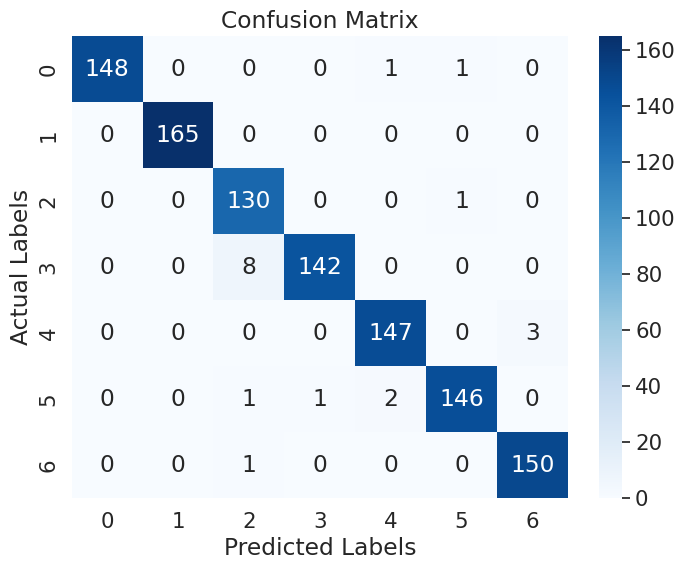

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       150
           1       1.00      1.00      1.00       165
           2       0.93      0.99      0.96       131
           3       0.99      0.95      0.97       150
           4       0.98      0.98      0.98       150
           5       0.99      0.97      0.98       150
           6       0.98      0.99      0.99       151

    accuracy                           0.98      1047
   macro avg       0.98      0.98      0.98      1047
weighted avg       0.98      0.98      0.98      1047



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

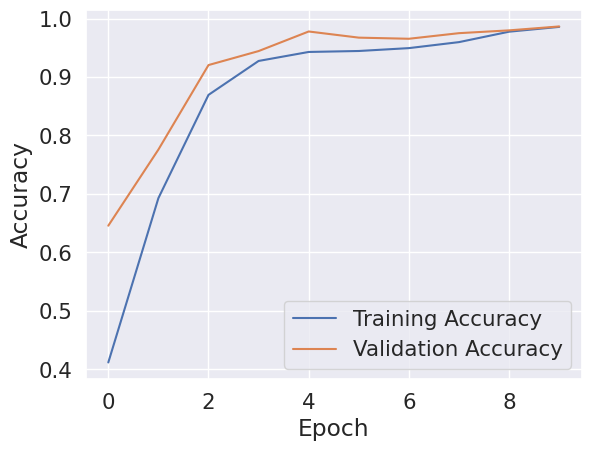

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

INCEPTION V3

In [ ]:
train_dir = os.path.join(split_dataset_path, 'train')
test_dir = os.path.join(split_dataset_path, 'test')
val_dir = os.path.join(split_dataset_path, 'val')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For 5 classes
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4872 images belonging to 7 classes.
Found 1044 images belonging to 7 classes.
Found 1047 images belonging to 7 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_100[0][0]']             
 ormalization)                  )                                                           

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
import time
start = time.process_time()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr]
)

Epoch 1/10
153/153 [==============================] - 148s 758ms/step - loss: 0.4554 - accuracy: 0.8475 - val_loss: 0.2090 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 2/10
153/153 [==============================] - 111s 725ms/step - loss: 0.1323 - accuracy: 0.9561 - val_loss: 0.0982 - val_accuracy: 0.9684 - lr: 1.0000e-04
Epoch 3/10
153/153 [==============================] - 112s 733ms/step - loss: 0.0970 - accuracy: 0.9682 - val_loss: 0.2605 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 4/10
153/153 [==============================] - 113s 741ms/step - loss: 0.0790 - accuracy: 0.9766 - val_loss: 0.0658 - val_accuracy: 0.9761 - lr: 1.0000e-04
Epoch 5/10
153/153 [==============================] - 113s 735ms/step - loss: 0.0555 - accuracy: 0.9805 - val_loss: 0.0841 - val_accuracy: 0.9761 - lr: 1.0000e-04
Epoch 6/10
153/153 [==============================] - 112s 731ms/step - loss: 0.0405 - accuracy: 0.9850 - val_loss: 0.1004 - val_accuracy: 0.9722 - lr: 1.0000e-04
Epoch 7/10
153/153 [==

In [ ]:
print(time.process_time() - start)

1204.9285961000005


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weight_path,'inceptionNet.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 15s 441ms/step - loss: 0.0473 - accuracy: 0.9828
Test Loss: 0.0472961850464344
Test Accuracy: 0.982807993888855


In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

Best Validation Accuracy: 0.9875478744506836
Corresponding Training Accuracy: 0.988916277885437


In [ ]:
loaded_model = load_model(os.path.join(weight_path,'inceptionNet.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = loaded_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 14s 395ms/step - loss: 0.0473 - accuracy: 0.9828
Test Loss: 0.0472961850464344
Test Accuracy: 0.982807993888855


33/33 [==============================] - 15s 423ms/step


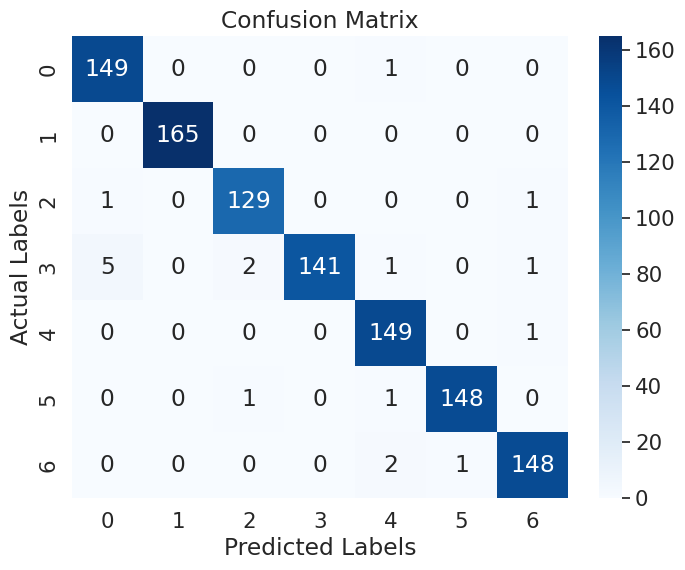

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       150
           1       1.00      1.00      1.00       165
           2       0.98      0.98      0.98       131
           3       1.00      0.94      0.97       150
           4       0.97      0.99      0.98       150
           5       0.99      0.99      0.99       150
           6       0.98      0.98      0.98       151

    accuracy                           0.98      1047
   macro avg       0.98      0.98      0.98      1047
weighted avg       0.98      0.98      0.98      1047



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

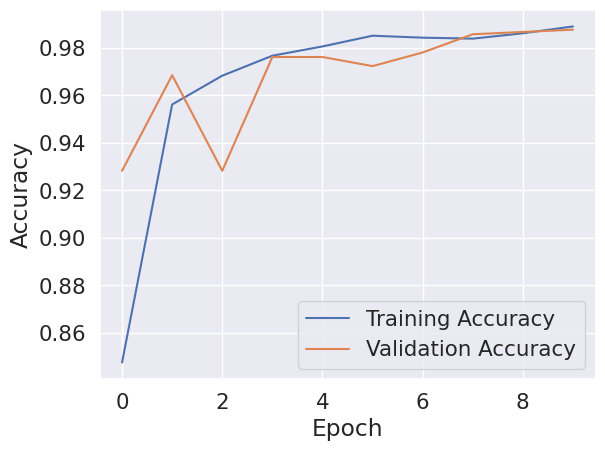

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Find Better CNN

In [ ]:
train_dir = os.path.join(split_dataset_path, 'train')
test_dir = os.path.join(split_dataset_path, 'test')
val_dir = os.path.join(split_dataset_path, 'val')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # For 5 classes
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4872 images belonging to 7 classes.
Found 1044 images belonging to 7 classes.
Found 1047 images belonging to 7 classes.


In [ ]:
def create_model():
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))


    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # model.add(Dropout(0.25))

    model.add(GlobalAveragePooling2D())

    # Flatten layer
    model.add(Flatten())

    # Dense layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))  # Dropout for regularization

    model.add(Dense(7, activation='softmax'))

    # model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 54, 54, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 26, 26, 128)     

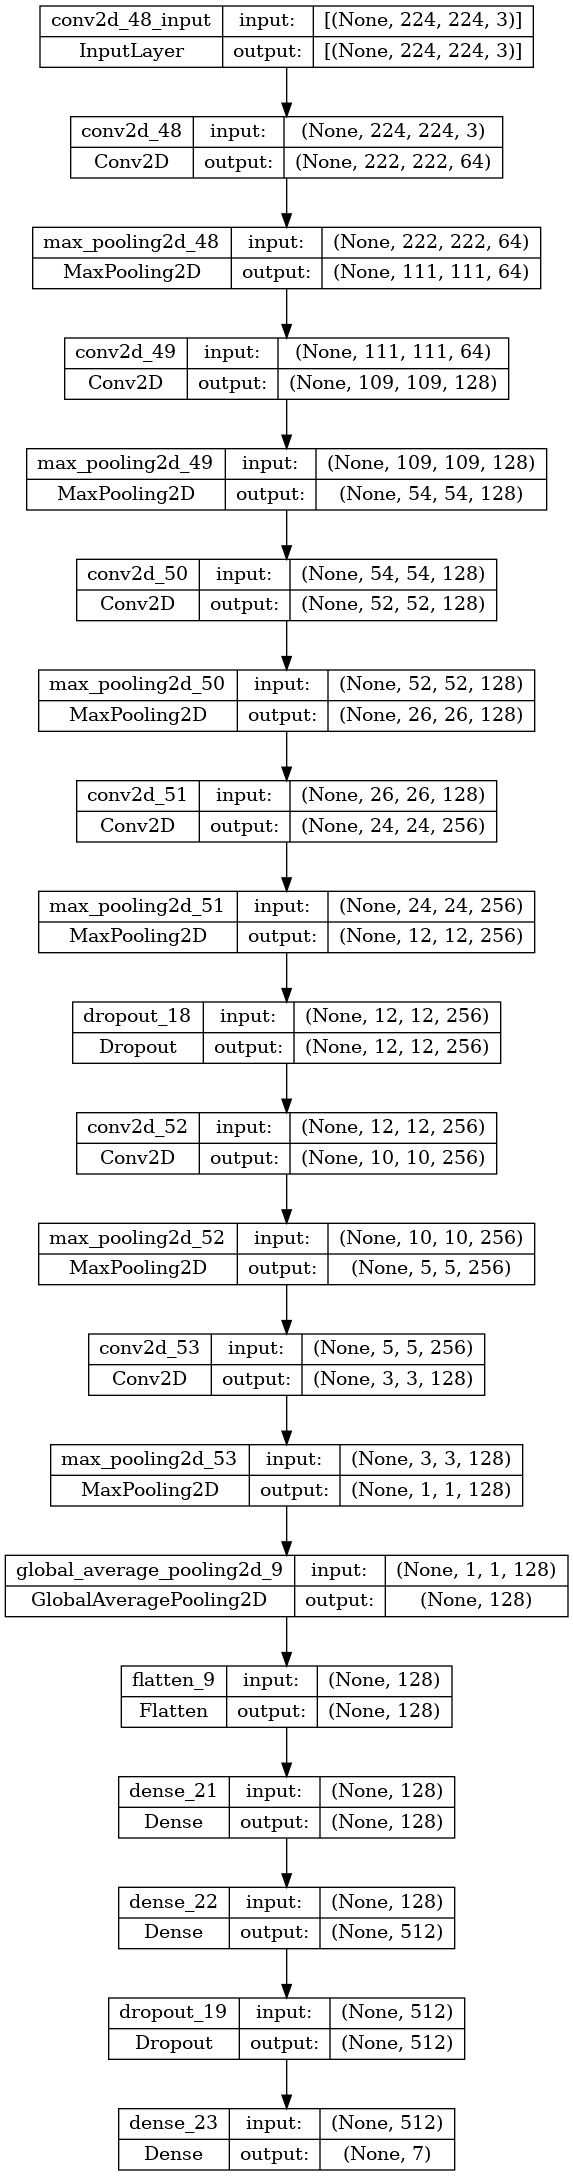

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0006), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
import time
start = time.process_time()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr]
)

Epoch 1/10


2024-04-24 06:18:47.485511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


153/153 [==============================] - 113s 711ms/step - loss: 1.6627 - accuracy: 0.2590 - val_loss: 1.4770 - val_accuracy: 0.3257 - lr: 6.0000e-04
Epoch 2/10
153/153 [==============================] - 108s 707ms/step - loss: 1.3669 - accuracy: 0.4224 - val_loss: 1.1940 - val_accuracy: 0.4895 - lr: 6.0000e-04
Epoch 3/10
153/153 [==============================] - 112s 732ms/step - loss: 1.2131 - accuracy: 0.5111 - val_loss: 1.1802 - val_accuracy: 0.5029 - lr: 6.0000e-04
Epoch 4/10
153/153 [==============================] - 111s 728ms/step - loss: 1.1382 - accuracy: 0.5447 - val_loss: 1.3122 - val_accuracy: 0.4904 - lr: 6.0000e-04
Epoch 5/10
153/153 [==============================] - 111s 725ms/step - loss: 1.0360 - accuracy: 0.5636 - val_loss: 1.0446 - val_accuracy: 0.5556 - lr: 6.0000e-04
Epoch 6/10
153/153 [==============================] - 111s 724ms/step - loss: 0.9055 - accuracy: 0.6375 - val_loss: 0.8407 - val_accuracy: 0.6695 - lr: 6.0000e-04
Epoch 7/10
153/153 [=============

In [ ]:
print(time.process_time() - start)

In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained model named 'model'
model.save(os.path.join(weight_path,'cnn.h5'))  # Save the model to a file

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
# Find the epoch with the best validation accuracy
best_epoch = np.argmax(history.history['val_accuracy'])

# Print the best validation accuracy and corresponding training accuracy
best_val_accuracy = history.history['val_accuracy'][best_epoch]
corresponding_train_accuracy = history.history['accuracy'][best_epoch]

print(f"Best Validation Accuracy: {best_val_accuracy}")
print(f"Corresponding Training Accuracy: {corresponding_train_accuracy}")

In [ ]:
loaded_model = load_model(os.path.join(weight_path,'cnn.h5'))  # Load the model from the HDF5 file
test_loss, test_accuracy = loaded_model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data using your model
predictions = model.predict(test_generator)

# Get the actual class labels
actual_labels = test_generator.classes

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(actual_labels), yticklabels=np.unique(actual_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate a classification report
class_report = classification_report(actual_labels, predicted_labels)
print(class_report)

In [ ]:
# For example, to plot the training and validation accuracy:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Visualization

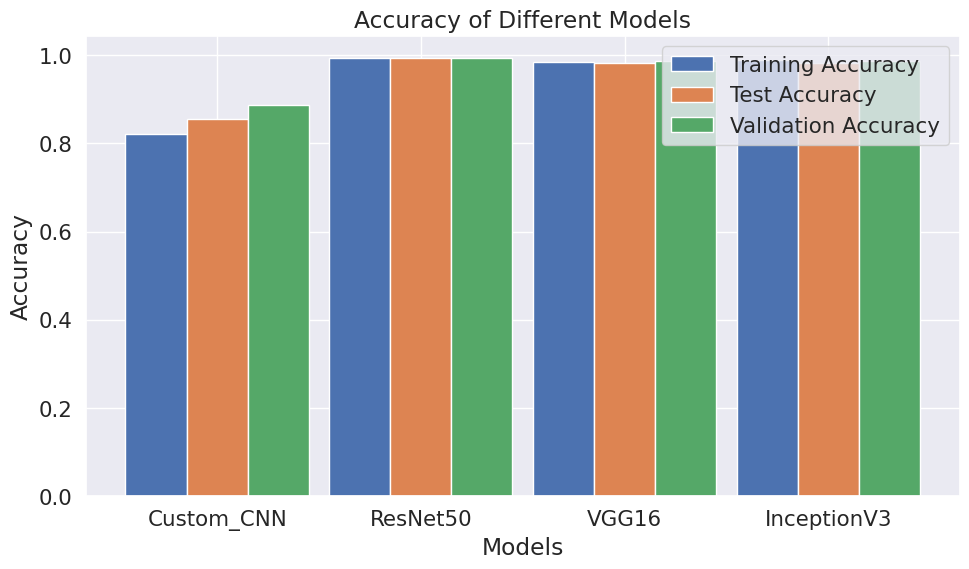

In [ ]:
import matplotlib.pyplot as plt

# Define model names and their accuracies
models = ['Custom_CNN', 'ResNet50', 'VGG16', 'InceptionV3']
training_accuracy = [0.820, 0.994, 0.985, 0.989]  # Example training accuracies
test_accuracy = [0.854, 0.993, 0.981, 0.982]  # Example test accuracies
validation_accuracy = [0.886, 0.993, 0.986, 0.987]  # Example validation accuracies

# Plotting the bar chart
x = range(len(models))
width = 0.3

plt.figure(figsize=(10, 6))

plt.bar(x, training_accuracy, width, label='Training Accuracy')
plt.bar([i + width for i in x], test_accuracy, width, label='Test Accuracy')
plt.bar([i + 2 * width for i in x], validation_accuracy, width, label='Validation Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks([i + width for i in x], models)
plt.legend()

plt.tight_layout()
plt.show()


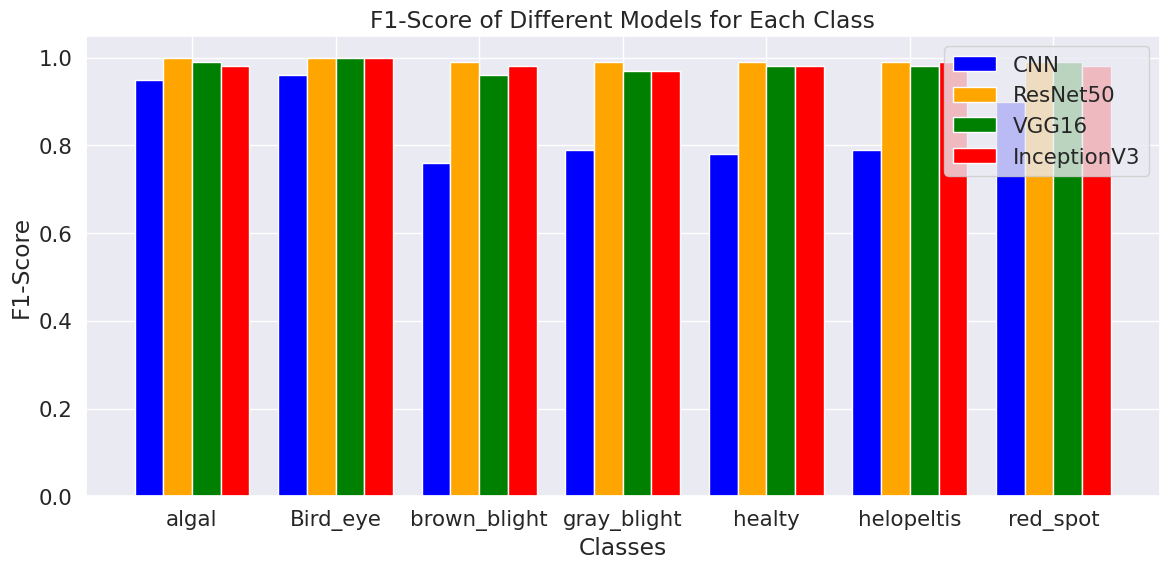

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
models = ['CNN', 'ResNet50', 'VGG16', 'InceptionV3']

# Define class names
classes = ['algal', 'Bird_eye', 'brown_blight', 'gray_blight', 'healty', 'helopeltis', 'red_spot']

# Define F1-score for each model and class
cnn_f1_score = [0.95, 0.96, 0.76, 0.79, 0.78, 0.79, 0.90]
resnet50_f1_score = [1.00, 1.00, 0.99, 0.99, 0.99, 0.99, 0.99]
vgg16_f1_score = [0.99, 1.00, 0.96, 0.97, 0.98, 0.98, 0.99]
inceptionv3_f1_score = [0.98, 1.00, 0.98, 0.97, 0.98, 0.99, 0.98]

# Define colors for each model
colors = ['blue', 'orange', 'green', 'red']

# Plotting the bar chart
x = np.arange(len(classes))
width = 0.2

plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x + i*width, eval(f'{model.lower()}_f1_score'), width, label=model, color=colors[i])

plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('F1-Score of Different Models for Each Class')
plt.xticks(x + 1.5*width, classes)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from tabulate import tabulate

# Define F1-scores for each model and class
f1_scores = [
    ['algal', 0.95, 1.00, 0.99, 0.98],
    ['Bird_eye', 0.96, 1.00, 1.00, 1.00],
    ['brown_blight', 0.76, 0.99, 0.96, 0.98],
    ['gray_blight', 0.79, 0.99, 0.97, 0.97],
    ['healty', 0.78, 0.98, 0.98, 0.98],
    ['helopeltis', 0.79, 0.99, 0.98, 0.99],
    ['red_spot', 0.90, 0.99, 0.99, 0.98]
]

# Define column headers
headers = ['Class', 'CNN', 'ResNet50', 'VGG16', 'InceptionV3']

# Print the table using tabulate
print(tabulate(f1_scores, headers=headers, tablefmt='grid'))


+--------------+-------+------------+---------+---------------+
| Class        |   CNN |   ResNet50 |   VGG16 |   InceptionV3 |
+==============+=======+============+=========+===============+
| algal        |  0.95 |       1    |    0.99 |          0.98 |
+--------------+-------+------------+---------+---------------+
| Bird_eye     |  0.96 |       1    |    1    |          1    |
+--------------+-------+------------+---------+---------------+
| brown_blight |  0.76 |       0.99 |    0.96 |          0.98 |
+--------------+-------+------------+---------+---------------+
| gray_blight  |  0.79 |       0.99 |    0.97 |          0.97 |
+--------------+-------+------------+---------+---------------+
| healty       |  0.78 |       0.98 |    0.98 |          0.98 |
+--------------+-------+------------+---------+---------------+
| helopeltis   |  0.79 |       0.99 |    0.98 |          0.99 |
+--------------+-------+------------+---------+---------------+
| red_spot     |  0.9  |       0.99 |   